# RFM Segmentation

#### About Dataset
Source:
Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.
Link: <a>https://www.kaggle.com/datasets/tunguz/online-retail

#### Data Set Information
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## 1. Importing Module

In [31]:
import numpy as np # Import NumPy for handling numerical operations
import pandas as pd # Import Pandas for data manipulation and analysis
pd.set_option('display.max_rows', 1000) # Set Pandas options to display a maximum of 1000 rows
from scipy.stats import norm 

# Import matplotlib, plotly and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Import Image from PIL to display images
from PIL import Image

# Set up matplotlib style
plt.style.available # Show list of available styles
plt.style.use('seaborn-v0_8-bright')

# Import warnings to ignore error
import warnings
warnings.filterwarnings("ignore")

# Import time and tqdm for measuring execution time
import time
import tqdm

# Import datetime to calculate recency and frequency
import datetime as dt

# Import pycountry for converting country name to ISO 3166-1 alpha-3 name
import pycountry

# Import preprocessing from sklearn to preprocessing data
from sklearn import preprocessing

# Import KMeans from sklearn.cluster for segmentation
from sklearn.cluster import KMeans

## 2. Loading Data

In [2]:
#  Loading dataset
filepath = r"..\\RFM-Customers-Segmentation\data\Online_Retail.xlsx"
df = pd.read_excel(filepath, dtype={'CustomerID': str, 'StockCode': str, "InvoiceNo": str})

# Create a DataFrame contains data of cancelled invoices
canceled = df[df['InvoiceNo'].str.contains(pat=r'C|c', regex=True)]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

# Drop missing data in the dataset
print('Number of missing data in the dataset:')
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nDrop missing data:")
item0 = df.shape[0]
df = df.dropna(subset = ['CustomerID'])
item1 = df.shape[0]
print(f"- Total {item0-item1} rows dropped for missing values.")

# Drop duplicates
item0 = df.shape[0]
df = df.drop_duplicates()
item1 = df.shape[0]
print("\nDrop duplicates:")
print(f"- Total {item0-item1} row dropped for duplicates.")

# Drop incorrect values 
print('\nIncorrect values:')
for col in ["Quantity", "UnitPrice"]:  
    item0 = df.shape[0]
    # UnitPrice and Quantity must greater than zero to be acceptable
    df = df[df[col]>0]
    item1 = df.shape[0]
    print(f'- There are {item0-item1} incorrect data (which less than or equal to zero) in {col} column were dropped.')

# Add CountryCode column
def country_to_iso_alpha(country_name): # Defind a function to convert country name to country code
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_3
    except LookupError:
        return None
df['CountryCode'] = df['Country'].apply(country_to_iso_alpha)

# Print Final Result
print("\nOverview:")
print(df.info())
df.head(10)

Number of missing data in the dataset:
Description      1454
CustomerID     135080
dtype: int64

Drop missing data:
- Total 135080 rows dropped for missing values.

Drop duplicates:
- Total 5225 row dropped for duplicates.

Incorrect values:
- There are 8872 incorrect data (which less than or equal to zero) in Quantity column were dropped.
- There are 40 incorrect data (which less than or equal to zero) in UnitPrice column were dropped.

Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,CountryCode
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,GBR
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,GBR
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,GBR
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,GBR
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,GBR
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,GBR
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,GBR
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,GBR
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,GBR
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08,GBR


## 3. Data Exploration

### Descriptive Statistic Analysis

In [3]:
# Descriptive Analysis
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,392692.0,13.119702,1.0,2.0,6.0,12.0,80995.0,180.492832
InvoiceDate,392692,2011-07-10 19:13:07.771892480,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392692.0,3.125914,0.001,1.25,1.95,3.75,8142.75,22.241836
TotalPrice,392692.0,22.6315,0.001,4.95,12.45,19.8,168469.6,311.099224


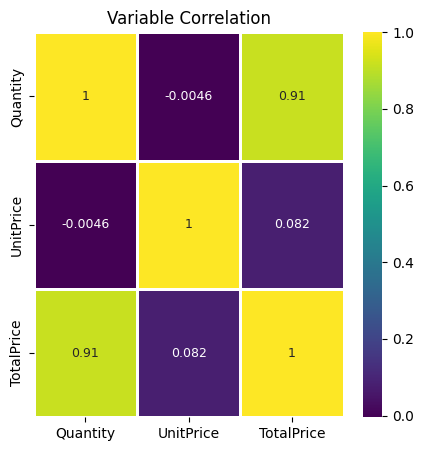

In [4]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, cmap = 'viridis',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation');

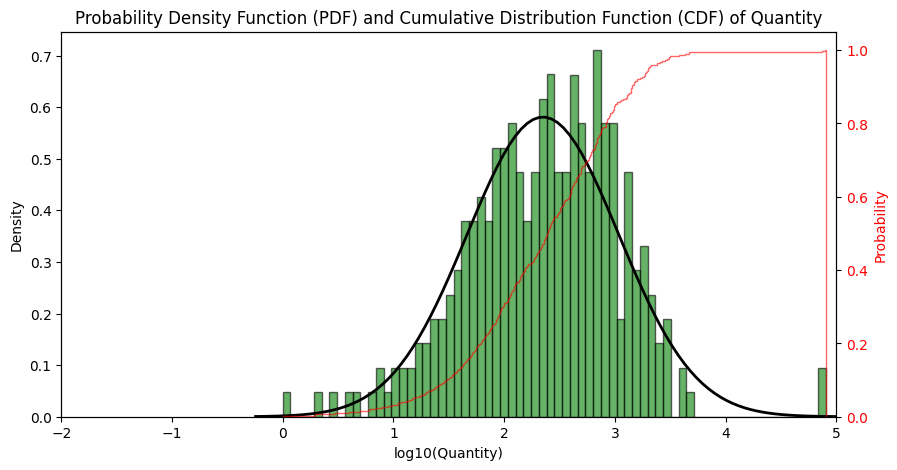

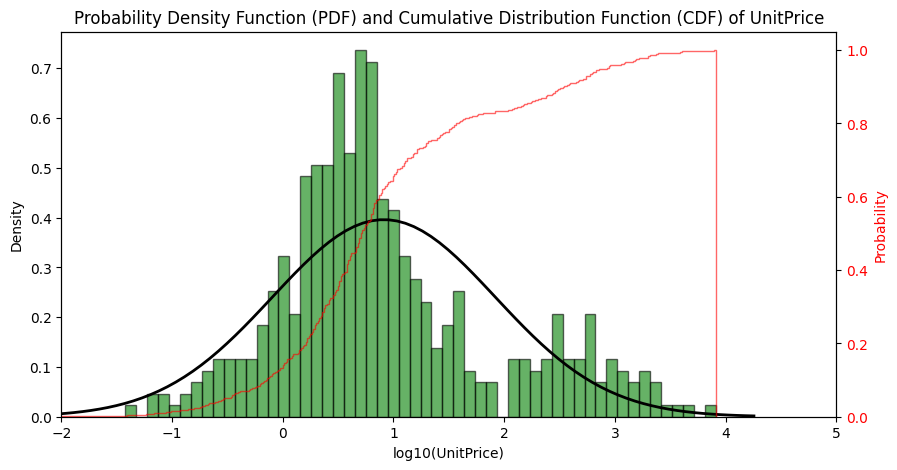

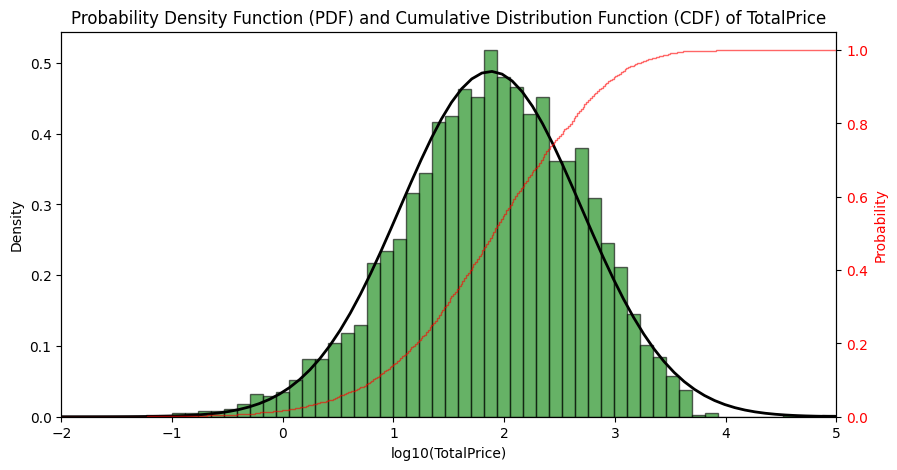

In [5]:
for col in ["Quantity", "UnitPrice", "TotalPrice"]:
    # Calculate Frequency of each col value
    stats_df = df.groupby(col).size().reset_index(name='frequency')

    # Initialize figure and axes instances
    fig, ax1 = plt.subplots(figsize=(10, 5))
    # Axes 1
    ax1.hist(np.log10(stats_df[col]), 
            bins=70, 
            density=True,
            alpha=0.6, 
            color='g',
            edgecolor = "black")  # Histogram for empirical PDF

    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, np.mean(np.log10(stats_df[col])), 
                np.std(np.log10(stats_df[col])))  # Theoretical PDF (assuming normal distribution)

    ax1.plot(x, p, 'k', linewidth=2)
    ax1.set_title(f'Probability Density Function (PDF) and Cumulative Distribution Function (CDF) of {col}')
    ax1.set_xlabel(f'log10({col})')
    ax1.set_ylabel('Density')
    ax1.set_xlim(-2, 5)

    # Axes 2
    ax2=ax1.twinx()
    ax2.hist(np.log10(stats_df[col]), 
            bins=500, 
            density=True, 
            cumulative=True, 
            alpha=0.6, 
            color='r', 
            histtype='step')  # Empirical CDF
    ax2.set_xlim(-2, 5)
    ax2.set_ylabel('Probability', color='r')
    ax2.tick_params(axis='y', labelcolor='r');


## Studying Countries by their Transactions

### Number of Transactions

#### Distribution of Transactions in around the world

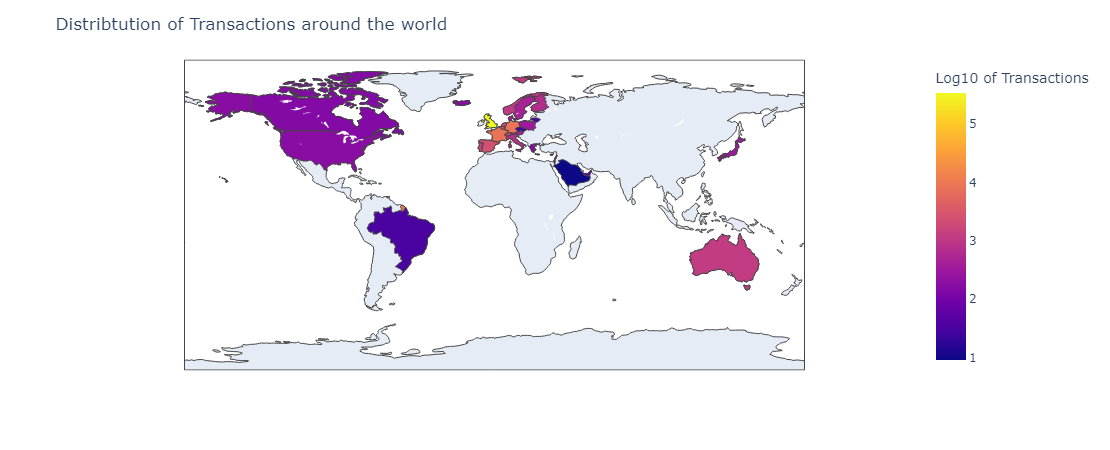

In [6]:
# Number of transactions in each country
stats_country_df = df.groupby(['Country','CountryCode']).size().reset_index(name="frequency")
stats_country_df.sort_values(by='frequency', ascending=False, inplace=True, ignore_index=True)
stats_country_df['log10_frequency'] = np.log10(stats_country_df['frequency'])

fig = px.choropleth(stats_country_df, locations="CountryCode",
                    color="log10_frequency", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data="frequency",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    labels={'log10_frequency': 'Log10 of Transactions'})
fig.update_layout(
    title_text = 'Distribtution of Transactions around the world'
    )
fig.show()
# fig.write_html('transactions-around-word.html')
Image.open(r".\plotly-objects\PNG\transactions-around-world.png")

#### Total number of Transactions in each Continent
As we see, most of the transactions came from Europe.

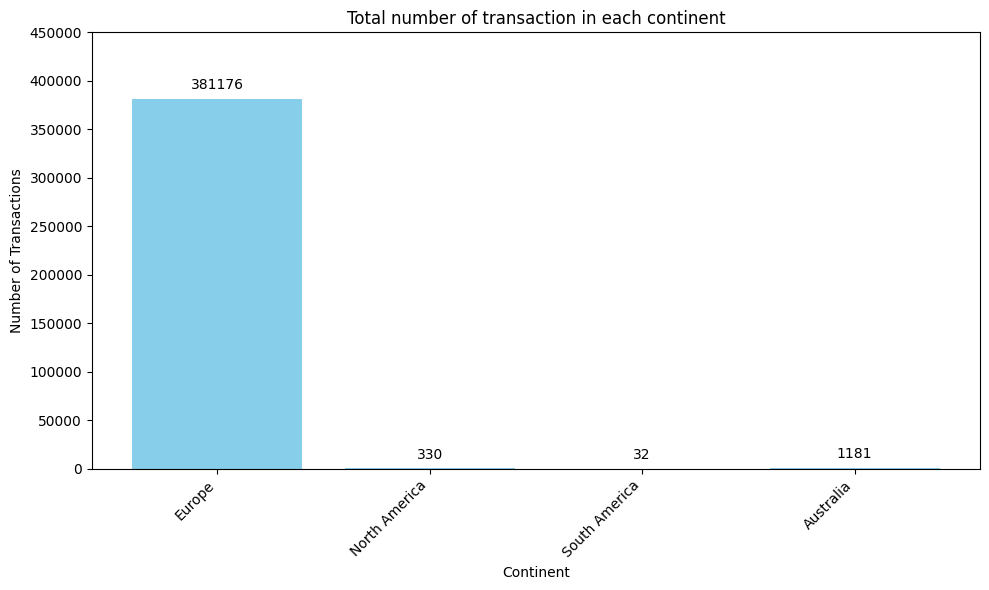

In [7]:
# Create a dictionary contains continents (as key) and CountryCode (as value)
continents_dict = {
    'Europe' : ['NOR', "ISL", "FIN", "SWE", "DNK", 
                "GBR", 'NLD', 'BEL', "DEU", "CZE", 
                "POL", "LTU", "FRA", "CHE", "AUT", 
                "ITA", "GRC", "ESP", "PRT"],
    'North America' : ["USA", "CAN"],
    'South America' : ["BRA"],
    'Australia' : ["AUS"],
}

# Calculate total transactions in each continent
total_transactions = {}
for continent , countries in continents_dict.items():
    value = stats_country_df[stats_country_df['CountryCode'].isin(countries)]['frequency'].sum()
    total_transactions[continent] = value

# Extracting keys (continents) and values (transactions) from the dictionary
continents = list(total_transactions.keys())
transactions = list(total_transactions.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(continents, transactions, color='skyblue')
# Add values on top of each bar
for i in range(len(continents)):
    plt.text(i, transactions[i] + 10000, str(transactions[i]), ha='center')
plt.xlabel('Continent')
plt.ylabel('Number of Transactions')
plt.title('Total number of transaction in each continent')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.ylim(0, 450000)
plt.show()

> Most of transactions came from Europe (about 99.74% of total transactions). Australia in second place with 1181 transactions (about 0.31% of total transactions)

#### Top 10 Countries With Highest Number of Transactions

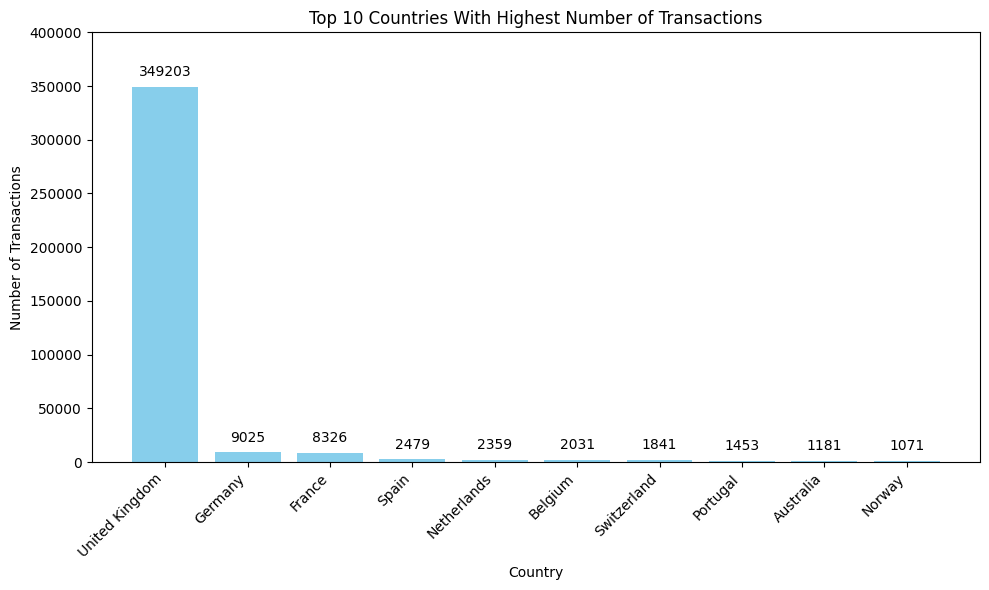

In [8]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(stats_country_df.head(10)["Country"], stats_country_df.head(10)['frequency'], color='skyblue')
# Add values on top of each bar
for i in range(len(stats_country_df.head(10)['Country'])):
    plt.text(i, stats_country_df.head(10)['frequency'].loc[i] + 10000, str(stats_country_df.head(10)['frequency'].loc[i]), ha='center')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.title('Top 10 Countries With Highest Number of Transactions')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.ylim(0, 400000)
plt.show()

> As shown in plot : 
   > - United Kingdom, Germany and France had highest transactions
   > - Most of transactions came from United Kingdom (349203 transactions, about 91.37% of total transactions)
   > - Autralia is the only country in the list  which is not belong to Europe

### Total Purchase Amount

#### Top 10 Countries With Highest Purchase Amount

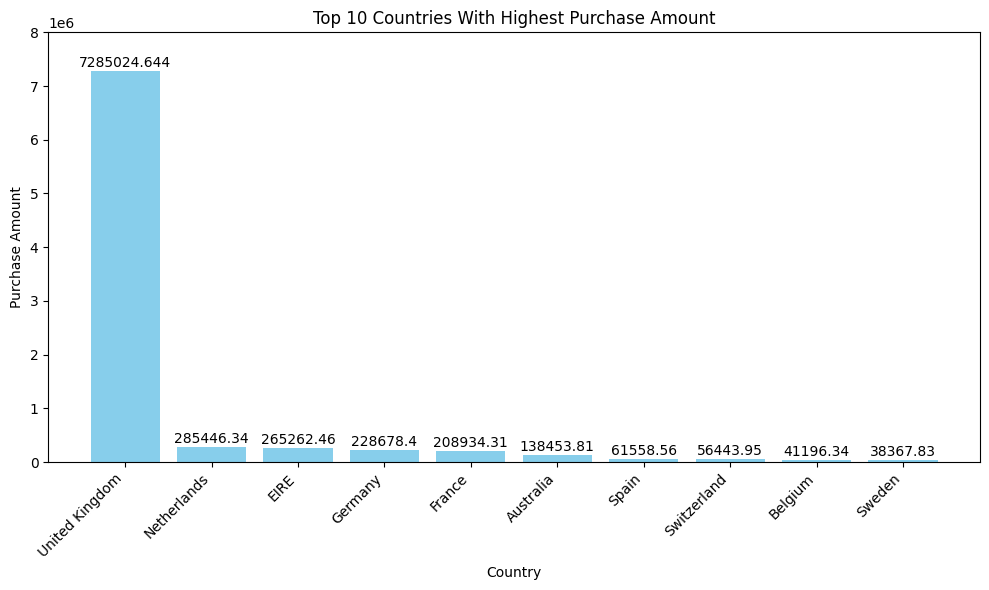

In [9]:
total_purchase = df.groupby(by="Country")['TotalPrice'].sum().sort_values(ascending=False).reset_index().head(10)
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(total_purchase["Country"], total_purchase['TotalPrice'], color='skyblue')
# Add values on top of each bar
for i in range(len(total_purchase['Country'])):
    plt.text(i, total_purchase['TotalPrice'].loc[i] + 70000, str(total_purchase['TotalPrice'].loc[i]), ha='center')
plt.xlabel('Country')
plt.ylabel('Purchase Amount')
plt.title('Top 10 Countries With Highest Purchase Amount')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.ylim(0, 8000000)
plt.show()

> We already know the UK was one of the countries which had the most transactions, here we can see the UK also had brought the most money to this business

### Average Purchase Amount

#### Average Purchase Amount in each Country

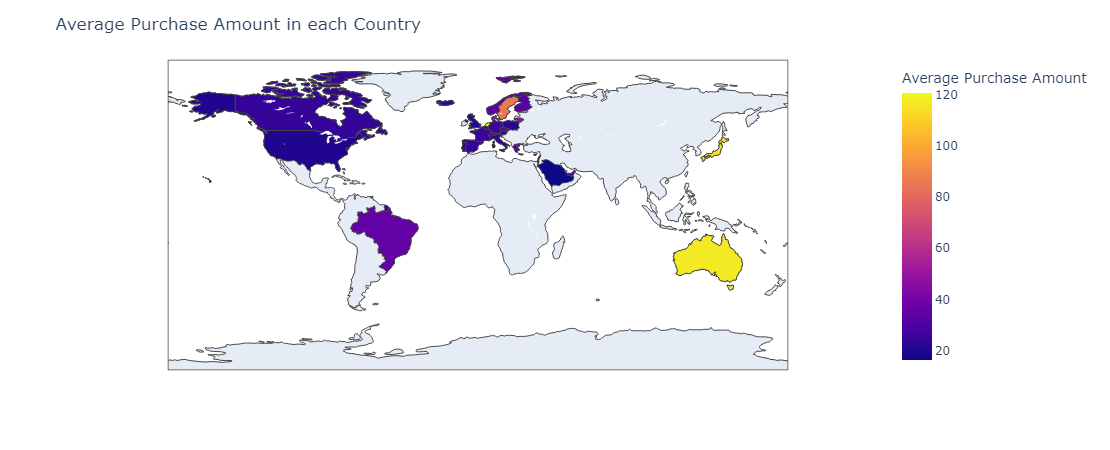

In [10]:
average_purchase_amount = df.groupby(by=['Country','CountryCode'])["TotalPrice"].mean().sort_values(ascending=False).reset_index()

# Choropleth map
fig = px.choropleth(average_purchase_amount, locations="CountryCode",
                    color="TotalPrice", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                    labels={'TotalPrice':'Average Purchase Amount'})
fig.update_layout(
    title_text = 'Average Purchase Amount in each Country',
    )
fig.show()
# fig.write_html('average-purchase-amount.html')
Image.open(r'.\plotly-objects\PNG\average-purchase-amount.png')

#### Top 10 Countries With Highest Average Purchase Amount

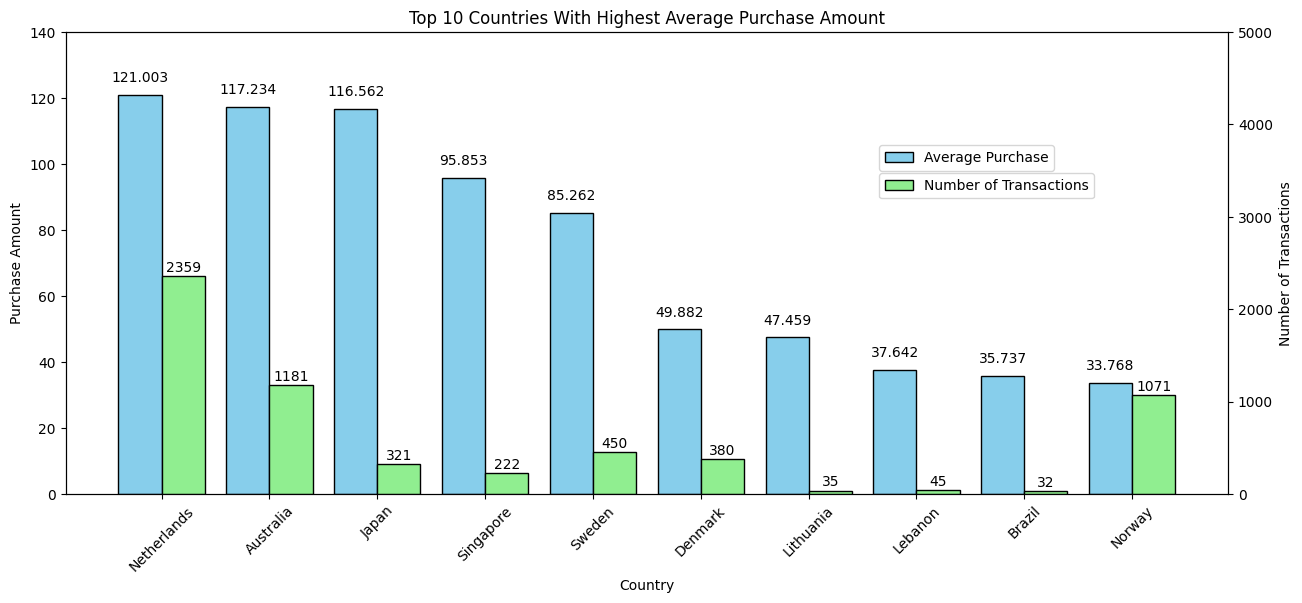

In [11]:
# Prepare dataset
average_purchase_amount = df.groupby(by=['Country','CountryCode']) \
                            ["TotalPrice"] \
                            .agg(['mean', 'size']) \
                            .sort_values(by='mean', ascending=False) \
                            .reset_index() \
                            .rename(mapper={'mean': 'AveragePurchase',
                                            'size': 'Transactions'}, axis=1) \
                            .head(10)
average_purchase_amount['AveragePurchase'] = average_purchase_amount['AveragePurchase'].apply(lambda x : round(x, 3))

# Plotting the bar chart
fig, ax1 = plt.subplots(figsize=(15,6))
X = average_purchase_amount["Country"]
X_axis = np.arange(len(X))
plt.xticks(X_axis, X)
# Axes 1
color1 = 'skyblue'
rect1 = ax1.bar(X_axis - 0.2, 
        average_purchase_amount['AveragePurchase'], 0.4,
        color=color1, 
        edgecolor='black',
        label="Average Purchase")
# Add values on top of each bar
for i in range(len(X_axis - 0.2)):
    ax1.text(i-0.2, average_purchase_amount['AveragePurchase'].loc[i] + 4, str(average_purchase_amount['AveragePurchase'].loc[i]), ha='center')
# Rotate x-axis labels for better readability
for tick in ax1.get_xticklabels():
    tick.set_rotation(45) 
ax1.set_ylim(0, 140)
ax1.set_xlabel('Country')
ax1.set_ylabel('Purchase Amount')
ax1.set_title('Top 10 Countries With Highest Average Purchase Amount')
# Axes 2
color2 = 'lightgreen'
ax2 = ax1.twinx()
rect2 = ax2.bar(X_axis + 0.2, 
        average_purchase_amount['Transactions'], 0.4,
        color=color2, 
        edgecolor='black',
        label='Number of Transactions')
# Add values on top of each bar
for i in range(len(X_axis + 0.2)):
    ax2.text(i+0.2, average_purchase_amount['Transactions'].loc[i] + 50, str(average_purchase_amount['Transactions'].loc[i]), ha='center')
ax2.set_ylim(0, 5000)
ax2.set_ylabel('Number of Transactions')
# Legend
ax1.legend(loc=(0.7,0.7))
ax2.legend(loc=(0.7,0.64))
plt.show();

> As shown in plot :
    > - Netherlands, Australia and Japan had highest average purchase amount

## 4. RFM Segmentation (using Kmeans)

### What is RFM Segmentation?
RFM segmentation allows marketers to target specific clusters of customers with communications that are much more relevant for their particular behavior – and thus generate much higher rates of response, plus increased loyalty and customer lifetime value. Like other segmentation methods, RFM segmentation is a powerful way to identify groups of customers for special treatment. RFM stands for recency, frequency and monetary. [1]

### What are Recency, Frequency and Monetary?
Recency (R): How much time has elapsed since a customer’s last activity or transaction with the brand? Activity is usually a purchase, although variations are sometimes used, e.g., the last visit to a website or use of a mobile app. In most cases, the more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to communications from the brand. [1]

Frequency (F): How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. And one-time-only customers are in a class of their own. [1]

Monetary (M): Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.

### Data Transformation

In [12]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [13]:
NOW = dt.datetime(2011, 12, 10)

# Calculate RFM
RFM = df.groupby("CustomerID").agg({'InvoiceDate': lambda x : (NOW - x.max()).days, # Recency
                                    "InvoiceNo": 'size', # Frequency
                                    'TotalPrice': 'sum'} # Monetary
                                   )  \
                                .reset_index() \
                                .rename(columns = {'InvoiceDate': 'Recency',
                                                  'InvoiceNo' : 'Frequency',
                                                  'TotalPrice': 'Monetary'})                           
# Discretization
RFM['RecencyDiscretized'] = pd.qcut(RFM['Recency'], 50,labels=False) 
RFM['RecencyDiscretized'] = RFM['RecencyDiscretized'] + 1
RFM['FrequencyDiscretized'] = pd.qcut(RFM['Frequency'],50,labels=False)
RFM['FrequencyDiscretized'] = RFM['FrequencyDiscretized']+1
RFM['MonetaryDiscretized']=pd.qcut(RFM['Monetary'], q=50, labels=False)
RFM['MonetaryDiscretized']=RFM['MonetaryDiscretized']+1

RFM

,CustomerID,Recency,Frequency,Monetary,RecencyDiscretized,FrequencyDiscretized,MonetaryDiscretized
0,12346,325,1,77183.60,49,1,50
1,12347,2,182,4310.00,2,45,47
2,12348,75,31,1797.24,31,21,39
3,12349,18,73,1757.55,13,34,39
4,12350,310,17,334.40,48,13,15
...,...,...,...,...,...,...,...
4333,18280,277,10,180.60,46,7,7
4334,18281,180,7,80.82,41,5,2
4335,18282,7,12,178.05,6,9,7
4336,18283,3,721,2045.53,3,50,40


### KMeans Clustering

#### Parameter Tuning

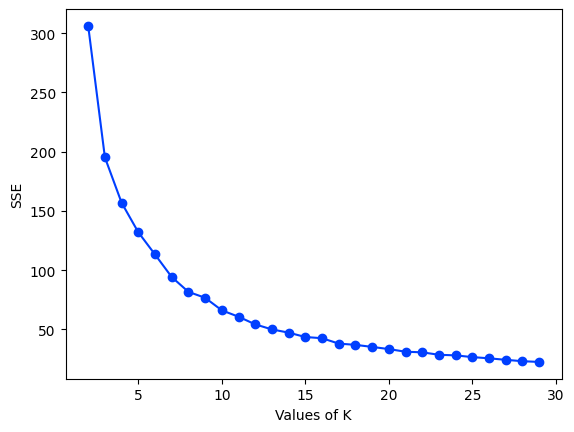

In [14]:
# Prepare training data
train_data = preprocessing.normalize(RFM[['RecencyDiscretized', 'FrequencyDiscretized', 'MonetaryDiscretized']])

# List to hold on the metrics for each value of K
results = []

# Executing the loop
for K in range(2, 30):
    model = KMeans(n_clusters = K)
    model.fit(train_data)
    results.append(model.inertia_)

# Plotting the final result
plt.plot(range(2, 30), results, 'o-')
plt.xlabel("Values of K")
plt.ylabel("SSE")
plt.show()

#### Train Model

In [15]:
# Initailize Model
kmeans = KMeans(n_clusters = 10, random_state=0)

# Train model
kmeans.fit(train_data)

# You can see the labels (clusters) assigned for each data point with the function labels_
kmeans.labels_

# Assigning the labels to the initial dataset
RFM['Cluster'] = kmeans.labels_
RFM

,CustomerID,Recency,Frequency,Monetary,RecencyDiscretized,FrequencyDiscretized,MonetaryDiscretized,Cluster
0,12346,325,1,77183.60,49,1,50,5
1,12347,2,182,4310.00,2,45,47,1
2,12348,75,31,1797.24,31,21,39,0
3,12349,18,73,1757.55,13,34,39,1
4,12350,310,17,334.40,48,13,15,4
...,...,...,...,...,...,...,...,...
4333,18280,277,10,180.60,46,7,7,2
4334,18281,180,7,80.82,41,5,2,2
4335,18282,7,12,178.05,6,9,7,3
4336,18283,3,721,2045.53,3,50,40,1


#### Visualize Result

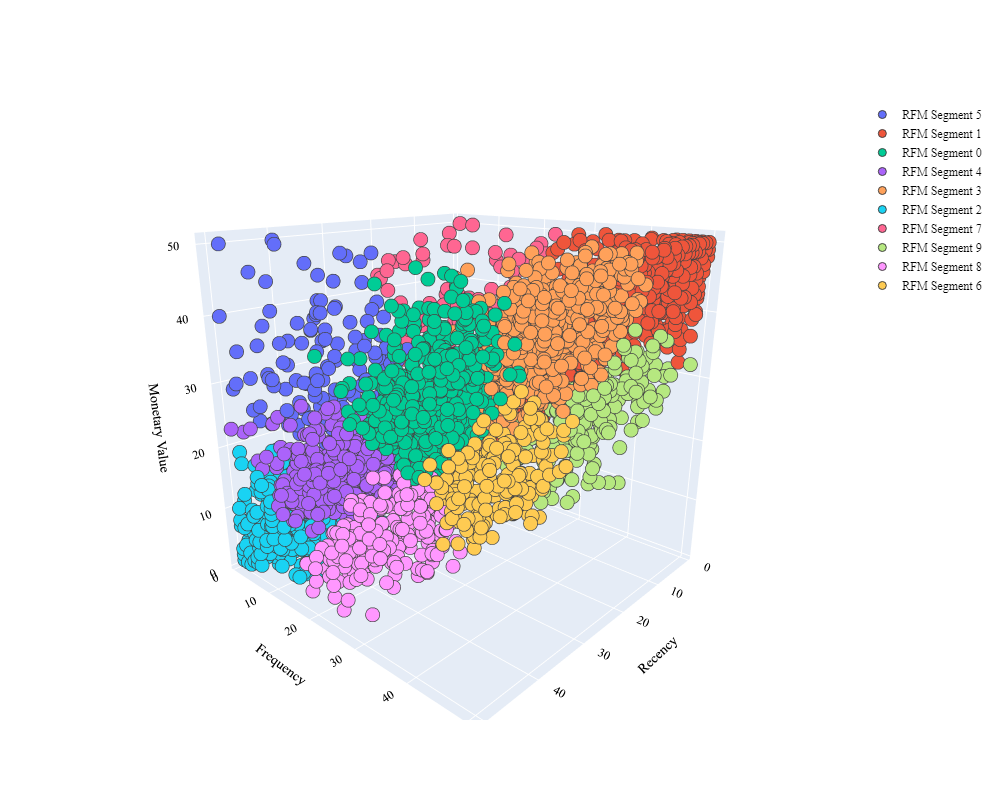

In [46]:
PLOT = go.Figure()

for C in list(RFM['Cluster'].unique()):
    
    PLOT.add_trace(go.Scatter3d(x = RFM[RFM['Cluster'] == C]['RecencyDiscretized'],
                                y = RFM[RFM['Cluster'] == C]['FrequencyDiscretized'],
                                z = RFM[RFM['Cluster'] == C]['MonetaryDiscretized'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'RFM Segment ' + str(C)))

PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Monetary Value', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

PLOT.show()
# PLOT.write_html('segmentation-result.html')
Image.open(r".\plotly-objects\PNG\segmentation-result.png")

#### Segmentation Analysis

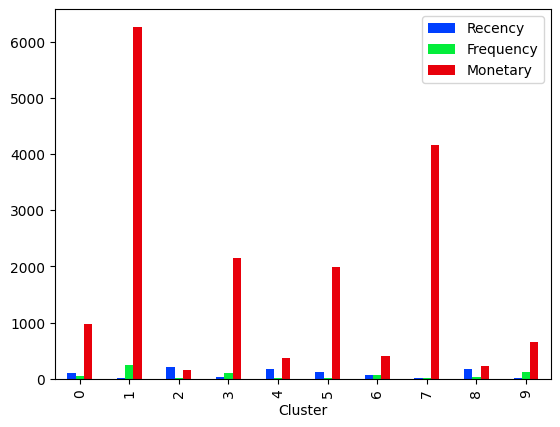

In [50]:
clustering_result = RFM.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().plot(kind='bar')

In [57]:
def my_round_function(x):
    return round(x, 2)
clustering_result = RFM.groupby('Cluster') \
                        [['Recency', 'Frequency', 'Monetary']] \
                        .mean() \
                        .reset_index()
clustering_result[['Recency', 'Frequency', 'Monetary']] = clustering_result[['Recency', 'Frequency', 'Monetary']].apply(my_round_function)
clustering_result

,Cluster,Recency,Frequency,Monetary
0,0,99.89,47.20,971.33
1,1,7.99,247.26,6263.11
2,2,210.75,7.69,153.62
3,3,38.53,112.11,2149.14
4,4,168.39,18.74,372.73
5,5,120.46,9.79,1998.90
6,6,63.75,74.23,406.25
7,7,18.54,19.27,4160.42
8,8,177.10,36.74,224.13
9,9,14.57,124.61,646.88


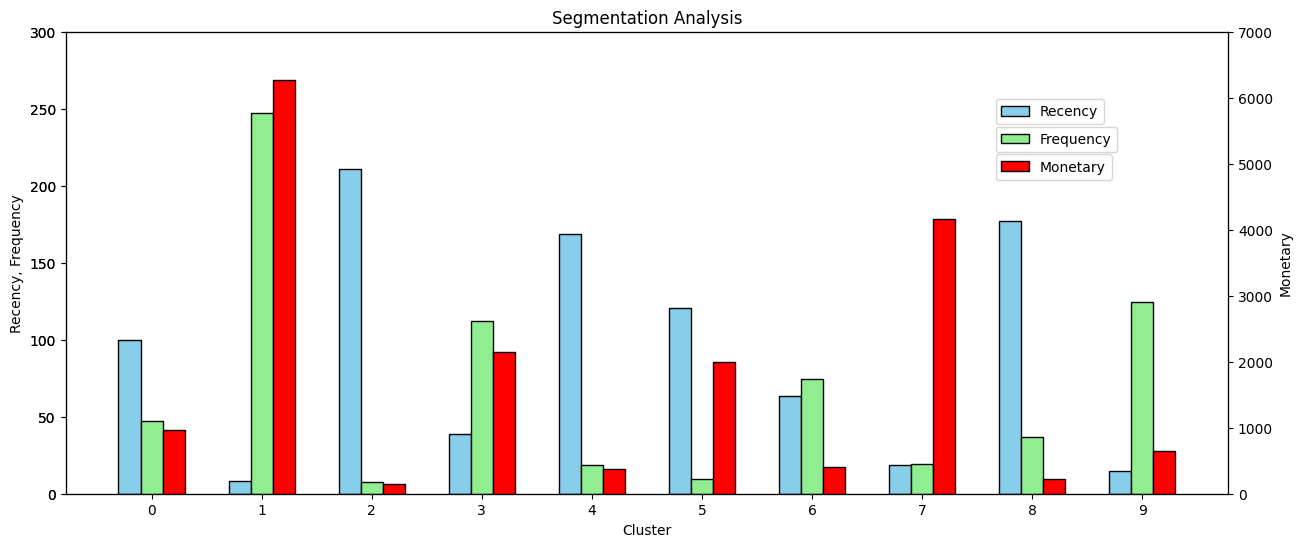

In [99]:
# Prepare dataset
clustering_result = RFM.groupby('Cluster') \
                        [['Recency', 'Frequency', 'Monetary']] \
                        .mean() \
                        .reset_index()
def my_round_function(x):
    return round(x, 2)
clustering_result[['Recency', 'Frequency', 'Monetary']] = clustering_result[['Recency', 'Frequency', 'Monetary']].apply(my_round_function)

# Plotting the bar chart
fig, ax1 = plt.subplots(figsize=(15,6))
X = clustering_result["Cluster"]
X_axis = np.arange(len(X))
plt.xticks(X_axis, X)
# Axes 1
color1 = 'skyblue'
ax1.bar(X_axis - 0.2, 
        clustering_result['Recency'], 
        0.2, # Bar width
        color=color1, 
        edgecolor='black',
        label="Recency")
ax1.set_ylim(0, 300)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Recency, Frequency')
ax1.set_title('Segmentation Analysis')
# Add values on top of each bar
# for i in range(len(X_axis - 0.2)): # Add values on top of each bar
#     ax1.text(i-0.2, clustering_result['Recency'].loc[i] + 4, str(clustering_result['Recency'].loc[i]), ha='center')

# Axes 2
color2 = 'lightgreen'
ax2 = ax1.twinx()
ax2.bar(X_axis, 
        clustering_result['Frequency'], 
        0.2, # Bar width
        color=color2, 
        edgecolor='black',
        label='Frequency')
ax2.set_ylim(0, 300)
# Add values on top of each bar
# for i in range(len(X_axis)):
#     ax2.text(i, clustering_result['Frequency'].loc[i] + 10, str(clustering_result['Frequency'].loc[i]), ha='center')

# Axes 3
color3 = 'red'
ax3 = ax2.twinx()
ax3.bar(X_axis + 0.2, 
        clustering_result['Monetary'], 
        0.2, # Bar width
        color=color3, 
        edgecolor='black',
        label='Monetary')
ax3.set_ylim(0, 7000)
ax3.set_ylabel('Monetary')
# Add values on top of each bar
# for i in range(len(X_axis + 0.2)):
#     ax3.text(i + 0.2, clustering_result['Monetary'].loc[i] + 300, str(clustering_result['Monetary'].loc[i]), ha='center')
ax1.legend(loc=(0.8, 0.80))
ax2.legend(loc=(0.8, 0.74))
ax3.legend(loc=(0.8, 0.68))
plt.show();